In [2]:
import torch
import matplotlib.pyplot as plt
from hydra import compose, initialize

import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parents[1]))

from maps_to_cosmology.encoder import Encoder
from maps_to_cosmology.datamodule import ConvergenceMapsModule

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initialize the config:

In [3]:
with initialize(config_path="../configs", version_base=None):
    cfg = compose("train_npe")

Instantiate the encoder using the checkpoint from a previous training run:

In [4]:
ckpt = "/data/scratch/blissWL_checkpoints/example_encoder.ckpt"
encoder = Encoder.load_from_checkpoint(ckpt)
encoder.eval()
encoder.to(device)

Encoder(
  (val_rmse): RootMeanSquaredError()
  (val_scatter): ScatterPlot()
  (test_rmse): RootMeanSquaredError()
  (test_scatter): ScatterPlot()
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=327680, out_features=128, bias=True)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): SiLU()
    (5): Linear(in_features=128, out_features=12, bias=True)
  )
)

Instantiate the test dataloader:

In [6]:
# this cell takes approximately 3 minutes
datamodule = ConvergenceMapsModule(
    data_dir=cfg.paths.data_dir,
    batch_size=cfg.convergence_maps.batch_size,
    num_workers=cfg.convergence_maps.num_workers,
    val_split=cfg.convergence_maps.val_split,
    test_split=cfg.convergence_maps.test_split,
    seed=cfg.seed,
)
datamodule.setup()
test_loader = datamodule.test_dataloader()

Loading data:   0%|          | 0/6248 [00:00<?, ?it/s]

Loaded 99968 samples
Maps shape: torch.Size([99968, 256, 256, 5])
Params shape: torch.Size([99968, 6])
Train samples: 79976
Val samples: 9996
Test samples: 9996


Load in the convergence maps from the test set and evaluate the encoder on them. Also load the correspoding cosmological parameters from the test set:

In [7]:
posterior_means = []
posterior_stdevs = []
true_params = []

with torch.no_grad():
    for maps, params in test_loader:
        maps = maps.to(device)
        
        out = encoder(maps)
        posterior_mean = out[:, 0::2]
        posterior_means.append(posterior_mean.cpu())
        
        posterior_stdev = out[:, 1::2].clamp(-10, 10).exp().sqrt()
        posterior_stdevs.append(posterior_stdev.cpu())
        
        true_params.append(params)

posterior_means = torch.cat(posterior_means, dim=0)
posterior_stdevs = torch.cat(posterior_stdevs, dim=0)
true_params = torch.cat(true_params, dim=0)

For each of the six cosmological parameters, create a scatterplot of the true parameter value versus the posterior mean. You'll want to use `plt.scatter()`. Arrange the six scatterplots in a 2x3 grid. How accurately do the posterior means approximate the true values? Explain why.

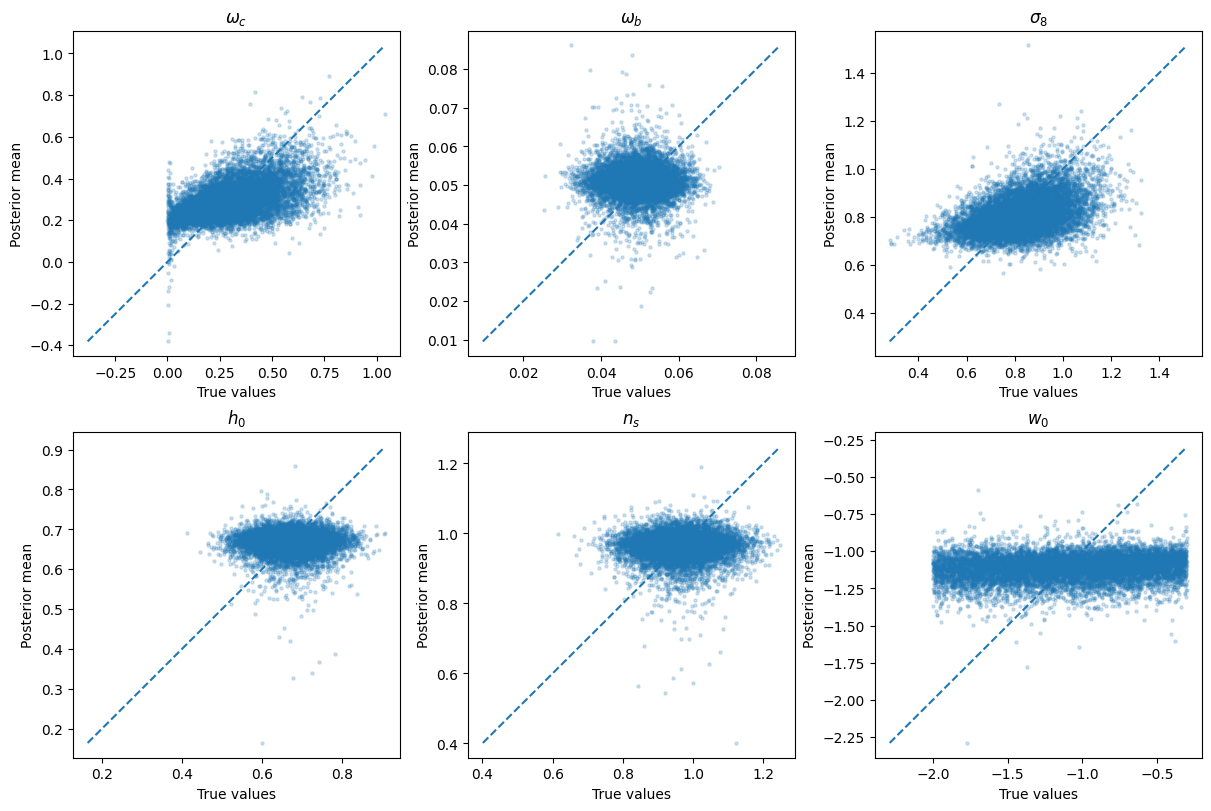

In [10]:
import numpy as np

names = [r'$\omega_c$', r'$\omega_b$', r'$\sigma_8$', r'$h_0$', r'$n_s$', r'$w_0$']

t = true_params.numpy()
m = posterior_means.numpy()

fig, axes = plt.subplots(2, 3, figsize=(12, 8), constrained_layout=True)
axes = axes.ravel()

for j, name in enumerate(names):
    ax = axes[j]
    ax.scatter(t[:, j], m[:, j], s=5, alpha=0.2)
    lo = min(t[:, j].min(), m[:, j].min())
    hi = max(t[:, j].max(), m[:, j].max())
    ax.plot([lo, hi], [lo, hi], "--")
    ax.set_title(name)
    ax.set_xlabel("True values")
    ax.set_ylabel("Posterior mean")

plt.show()


For $\omega_c$ and $\sigma_8$, posterior means are close to true values. For $\omega_b$, $h_0$, $n_s$ and $w_0$, the accuracy of posterior means are low.
The reason might be that the encoder is flatten MLP, which may capture global statistics, like the average value, but ignore subtle features.